# Monte Carlo Pricing of a European Call Option

Simulating the price of a European call option using Monte Carlo methods in the Black–Scholes setting.

### Aims

1. Motivate the use of Monte Carlo methods in option pricing  
2. Establish the financial framework  
3. Implement simulation of terminal prices under Black–Scholes  
4. Analyse convergence behaviour  
5. Examine variance reduction techniques  
6. Investigate Greeks and their role in hedging strategies  
7. Summarise conclusions and numerical observations


## Introduction

Monte Carlo methods play a central role in quantitative finance.  
Many derivatives depend on the full distribution of future asset prices, and in such settings the price cannot be expressed in closed form. Instead, one evaluates expectations of discounted payoffs numerically. Even when an analytical expression is available, Monte Carlo provides a transparent framework for examining numerical accuracy, sampling error, and the behaviour of estimators in a controlled environment.

In the Black-Scholes model the value of a European claim may be written as  
$$ \mathbb{E}[e^{-rT} f(S_T)],$$
so pricing reduces to approximating an expectation under the risk-neutral measure. Monte Carlo replaces this expectation with an average over simulated asset paths, yielding an estimator that converges at the universal rate $O(N^{-1/2})$ independently of model dimension.

Working in a setting where analytical prices and sensitivities are known allows us to measure the performance of Monte Carlo directly. This provides a benchmark against which we can study convergence, investigate variance reduction techniques, and assess the numerical stability of Greek estimators. These ideas become essential when moving beyond models with closed-form solutions.

### Scope

This notebook investigates the numerical behaviour of Monte Carlo pricing for a European call option under Black-Scholes. The aims are to examine:

- how accuracy depends on the number of simulated paths,  
- how different variance reduction methods affect the error profile,  
- the performance of Delta and Gamma estimators,  
- how such Greeks feeds into a discrete-time hedging strategy.

Although the Black-Scholes formula provides exact benchmark values, the methods and observations generalise to models where no closed form exists. The controlled setting therefore offers a clean environment in which to understand the strengths and limitations of Monte Carlo techniques before applying them more broadly.


## Financial Setup
### Background

A European call option gives the holder the right to buy an asset at price $K$ at time $T$.

Notation:
- $S_0$: current stock price  
- $K$: strike  
- $T$: maturity  
- $r$: constant risk-free rate  
- $\sigma$: volatility  

The payoff at maturity is

$$
(S_T - K)^+ = \max(S_T - K, 0).
$$

After time $T$ the contract expires, so this payoff fully determines its value.

### Discounting

A value $X$ received at time $T$ has present value

$$
e^{-rT} X.
$$

This discount factor always appears in risk-neutral pricing.

### Black-Scholes Dynamics

Under the risk-neutral measure the stock price satisfies

$$
dS_t = r S_t\,dt + \sigma S_t\,dW_t,
$$

where $W_t$ is standard Brownian motion.

The explicit solution is

$$
S_T = S_0 \exp\!\left( (r - \tfrac12 \sigma^2)T + \sigma\sqrt{T}\,Z \right),
$$

with $Z \sim N(0,1)$.  
Thus, a single sample of $Z$ generates a full simulation of $S_T$.

### Risk-Neutral Price and Monte Carlo Approximation

The value of the call option today is

$$
C_0 = e^{-rT}\,\mathbb{E}\big[(S_T - K)^+\big].
$$

Monte Carlo approximates this by:

1. generating $Z^{(i)} \sim N(0,1)$  
2. computing $S_T^{(i)}$ from the formula above  
3. computing $(S_T^{(i)} - K)^+$  
4. averaging these values  
5. multiplying by $e^{-rT}$.

The estimator is

$$
\widehat{C}_0^{(N)}
=
e^{-rT}
\frac{1}{N}
\sum_{i=1}^N (S_T^{(i)} - K)^+.
$$

We will verify that as $N \to \infty$,

$$
\widehat{C}_0^{(N)} \to C_0.
$$


## Simulation

First we simulate $S_T$ prices using the closed form of the Black-Scholes equation:
$$
S_T = S_0 \exp\!\left( (r - \tfrac12 \sigma^2)T + \sigma\sqrt{T}\,Z \right),
$$

$$
Z \sim N(0,1).
$$

### Libraries and Parameters

In [1]:
import os
os.makedirs("figs", exist_ok=True)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm




In [3]:
# parameters 
S0 = 100.0      # initial stock price
K = 100.0       # strike 
T = 1.0         # maturity in years
r = 0.05        # risk-free rate
sigma = 0.2     # volatility

### Terminal Price Generator

In [4]:
def simulate_ST(S0, r, sigma, T, N, rng=None):

    if rng is None:
        rng = np.random.default_rng()
    Z = rng.standard_normal(N)           # generate Z
    drift = (r - 0.5 * sigma**2) * T     # calculate drift
    diffusion = sigma * np.sqrt(T) * Z   # calculate diffusion
    ST = S0 * np.exp(drift + diffusion)  # S_T = S_0 * exp((r - 0.5 * sigma**2) * T + sigma * sqrt(T) * Z)
    return ST

# sanity check
N_test = 5
ST_samples = simulate_ST(S0, r, sigma, T, N_test)
ST_samples


array([ 76.49759494, 127.28112069, 124.76486252, 109.12342215,
        77.50299478])

### Monte Carlo Estimator

Given simulated terminal prices $S_T^{(i)}$, the discounted Monte Carlo estimator 
for the European call price is

$$
\widehat{C}_0^{(N)} 
= e^{-rT} \frac{1}{N} \sum_{i=1}^N (S_T^{(i)} - K)^+,
$$
(average of discounted expected outcomes). 

To simulate, we;
1. compute $S_T^{(i)}$ under Black-Scholes (above),
2. compute the payoff $(S_T^{(i)} - K)^+ = \max(S_T^{(i)} - K, 0)$,
3. average these payoffs,
4. discount by $e^{-rT}$.


In [5]:
def mc_european_call(S0, K, r, sigma, T, N, rng=None):
    """
    Monte Carlo price of a European call using N samples.
    """
    ST = simulate_ST(S0, r, sigma, T, N, rng=rng)
    payoffs = np.maximum(ST - K, 0.0)
    discount_factor = np.exp(-r * T)
    price_estimate = discount_factor * np.mean(payoffs)
    return price_estimate

# test
rng = np.random.default_rng(123)
price_mc = mc_european_call(S0, K, r, sigma, T, N=10_000, rng=rng)
price_mc


np.float64(10.529530410662687)

### Comparison with Analytical Results

We verify the Monte Carlo estimator by comparing its output across different strikes $K$ with the  Black-Scholes prices. A European call price should be a decreasing function of $K$ and approach $0$ for large $K$.

First we create a function which generates analytic $C_{BS}$:

$$
C_{\text{BS}}
=
S_0 \,\Phi(d_1)
-
K e^{-rT} \,\Phi(d_2),
$$
where
$$
d_1
=
\frac{
\ln\!\left(\frac{S_0}{K}\right)
+
\left(r + \tfrac{1}{2}\sigma^2\right)T
}{
\sigma\sqrt{T}
},
\qquad
d_2 = d_1 - \sigma\sqrt{T},
$$

and $\Phi$ is the normal cumulative distribution function

In [6]:
# analytic solution

def bs_call_price(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 0.5*sigma*sigma)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0 * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

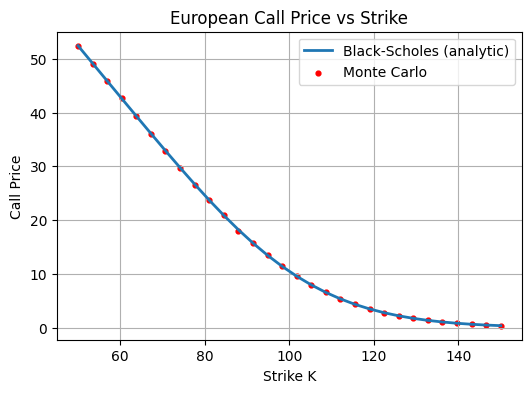

In [7]:
rng = np.random.default_rng(42)

K_values = np.linspace(50, 150, 30)
mc_prices = []
bs_prices = []

for K_test in K_values:
    mc_price = mc_european_call(S0, K_test, r, sigma, T, N=50_000, rng=rng)
    bs_price = bs_call_price(S0, K_test, r, sigma, T)
    mc_prices.append(mc_price)
    bs_prices.append(bs_price)

plt.figure(figsize=(6,4))
plt.plot(K_values, bs_prices, label="Black-Scholes (analytic)", lw=2)
plt.scatter(K_values, mc_prices, label="Monte Carlo", color='red', s=12)
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("European Call Price vs Strike")
plt.grid(True)
plt.legend()
plt.savefig("figs/european_call_price_vs_strike.png", dpi=300, bbox_inches="tight")

plt.show()


### Convergence Analysis

We run the simulation for different values of N and observe the rate of convergence.

N =     100 | RMSE = 1.442087
N =     316 | RMSE = 0.820889
N =    1000 | RMSE = 0.486100
N =    3162 | RMSE = 0.268047
N =   10000 | RMSE = 0.142840
N =   31622 | RMSE = 0.087126
N =  100000 | RMSE = 0.046139
N =  316227 | RMSE = 0.024968
N = 1000000 | RMSE = 0.014897


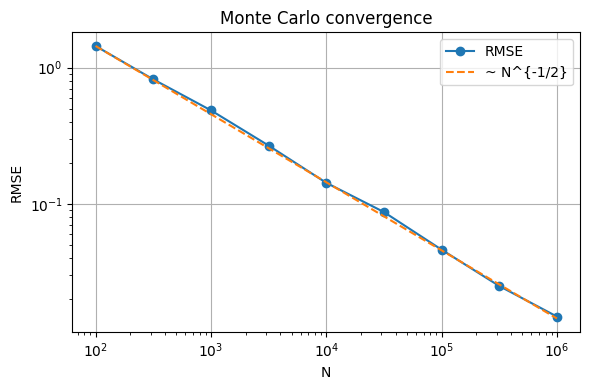

In [8]:
true_price = bs_call_price(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)
M = 500

rmse = []

rng = np.random.default_rng(123)

for N in N_values:
    samples = np.empty(M)
    for i in range(M):
        samples[i] = mc_european_call(S0, K, r, sigma, T, N, rng=rng)

    err = samples - true_price
    rmse_N = np.sqrt(np.mean(err**2))
    rmse.append(rmse_N)

    print(f"N = {N:7d} | RMSE = {rmse_N:.6f}")

rmse = np.array(rmse)

# reference line proportional to N^{-1/2}
c = rmse[0] * np.sqrt(N_values[0])
theory = c / np.sqrt(N_values)

plt.figure(figsize=(6,4))
plt.loglog(N_values, rmse, marker='o', label="RMSE")
plt.loglog(N_values, theory, '--', label="~ N^{-1/2}")

plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("Monte Carlo convergence")

plt.grid(True, which="major")   
plt.legend()
plt.tight_layout()
plt.savefig("figs/monte_carlo_convergence.png", dpi=300, bbox_inches="tight")
plt.show()

We can observe that the estimator converges at the expected rate of $N^{-\frac{1}{2}}$ (according to CLT).

## Variance Reduction

Variance reduction techniques aim to improve the efficiency of the Monte Carlo estimator.

The standard estimator for a discounted payoff satisfies
$$
\operatorname{Var}(\hat C_N)
=
\frac{\sigma_{\text{payoff}}^{2}}{N},
\qquad
\text{RMSE}(\hat C_N)
= 
O(N^{-1/2}),
$$
where we use RMSE since $\hat{C_N}$ is an unbiased esitmator.
The convergence rate cannot be improved, but the constant $\sigma_{\text{payoff}}^{2}$ can be reduced by constructing an alternative unbiased estimator with smaller variance. This shifts the error curve downward while preserving the $N^{-1/2}$ decay.




### Antithetic variates

Antithetic variates aim to reduce variance by exploiting symmetry of the normal distribution.

Instead of simulating one standard normal shock $Z \sim \mathcal{N}(0,1)$ per path, we simulate pairs $(Z, -Z)$.  
For each pair we obtain two terminal prices,
$$
S_T^{(+)} = S_0 \exp\big((r - \tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,Z\big),
\qquad
S_T^{(-)} = S_0 \exp\big((r - \tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,(-Z)\big),
$$
and average the corresponding payoffs.  
For a monotone (only increasing) payoff such as a European call, the payoffs based on $Z$ and $-Z$ are negatively correlated, so their average has smaller variance than either payoff alone (since our function of $S_T$ is non-linear).  
The Monte Carlo estimator is then obtained by averaging these pairwise–averaged payoffs over all simulated pairs.

We write the function below, then compare it to our original method.

In [9]:
def mc_european_call_antithetic(S0, K, r, sigma, T, N, rng=None):
    """
    Monte Carlo price of a European call using antithetic variates

    N is the total number of paths requested.
    We generate N//2 normal draws Z and reuse them as (Z, -Z)
    so the effective number of simulated paths is 2 * (N//2)
    """
    if rng is None:
        rng = np.random.default_rng()

    M = N // 2   # number of Z-pairs
    Z = rng.standard_normal(M)

    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z

    # antithetic terminal prices
    ST_plus  = S0 * np.exp(drift + diffusion)
    ST_minus = S0 * np.exp(drift - diffusion)

    # corresponding payoffs
    payoff_plus  = np.maximum(ST_plus  - K, 0.0)
    payoff_minus = np.maximum(ST_minus - K, 0.0)

    # average over each pair
    payoff_pair = 0.5 * (payoff_plus + payoff_minus)

    discount_factor = np.exp(-r * T)
    price_estimate = discount_factor * np.mean(payoff_pair)

    return price_estimate

# sanity check
rng = np.random.default_rng(123)

N_paths = 50_000
price_plain = mc_european_call(S0, K, r, sigma, T, N_paths, rng=rng)
price_anti  = mc_european_call_antithetic(S0, K, r, sigma, T, N_paths, rng=rng)
price_bs    = bs_call_price(S0, K, r, sigma, T)

price_plain, price_anti, price_bs

(np.float64(10.483698592512408),
 np.float64(10.439590579971654),
 np.float64(10.450583572185565))

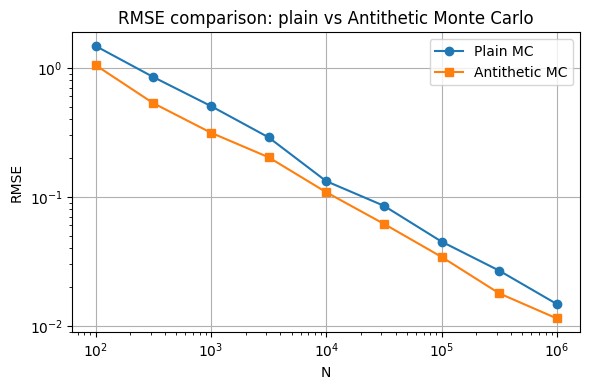

In [10]:
true_price = bs_call_price(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)
R = 200  # repetitions per N

rmse_plain = []
rmse_anti = []

rng = np.random.default_rng(123)

for N in N_values:
    err_plain = np.empty(R)
    err_anti  = np.empty(R)

    for i in range(R):
        price_plain = mc_european_call(S0, K, r, sigma, T, N, rng=rng)
        price_anti  = mc_european_call_antithetic(S0, K, r, sigma, T, N, rng=rng)

        err_plain[i] = price_plain - true_price
        err_anti[i]  = price_anti  - true_price

    rmse_plain.append(np.sqrt(np.mean(err_plain**2)))
    rmse_anti.append(np.sqrt(np.mean(err_anti**2)))

rmse_plain = np.array(rmse_plain)
rmse_anti  = np.array(rmse_anti)

plt.figure(figsize=(6, 4))
plt.loglog(N_values, rmse_plain, marker='o', label="Plain MC")
plt.loglog(N_values, rmse_anti,  marker='s', label="Antithetic MC")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("RMSE comparison: plain vs Antithetic Monte Carlo")
plt.grid(True, which="major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/RMSE_comparison_antithetic_monte_carlo.png", dpi=300, bbox_inches="tight")
plt.show()


We observe that both still decay at $N^{-\frac{1}{2}}$, but in the antithetic case there is a vertical shift. This makes sense since we haven't changed the convergence rate, but our variance is lower and we have reduced "fluctuation", hence a reduced RMSE.

### Control Variates

Let $X = f(S_T)$ denote the discounted payoff.  
The idea is to introduce a second random variable $Y$, simulated alongside $X$, whose expectation is known in closed form.  
The modified estimator takes the form
$$
\hat C_N^{\mathrm{cv}}
=
\hat C_N
-
\beta\,\big( \overline{Y}_N - \mathbb{E}[Y] \big),
$$
where
$$
\hat C_N = \frac{1}{N}\sum_{i=1}^N X_i,
\qquad
\overline{Y}_N = \frac{1}{N}\sum_{i=1}^N Y_i.
$$

The parameter $\beta$ controls the extent to which fluctuations in $Y$ are used to cancel fluctuations in $X$.  
Minimising the variance of $\hat C_N^{\mathrm{cv}}$ gives the optimal choice
$$
\beta^\ast
=
\frac{\operatorname{Cov}(X,Y)}{\operatorname{Var}(Y)}.
$$

For European options, a natural choice of control variate is the terminal stock price $Y=S_T$, since
$$
\mathbb{E}[S_T]=S_0 e^{rT},
$$
and $f(S_T)$ is strongly correlated with $S_T$.  
With this choice, the estimator remains unbiased and exhibits a substantial reduction in variance.

Put simply, we choose a Y correlated with X and use this correlation to reduce the error which is "explained" in the variable Y.


In [11]:
def mc_european_call_cv(S0, K, r, sigma, T, N, rng=None):    # Control variate Monte Carlo estimator for a European call

    
    # simulate ST
    ST = simulate_ST(S0, r, sigma, T, N, rng=rng)

    # payoff
    X = np.exp(-r * T) * np.maximum(ST - K, 0.0)

    # control-variate
    Y = ST
    EY = S0 * np.exp(r * T)   # exact E[S_T] under risk-neutral measure

    # sample means
    X_mean = X.mean()
    Y_mean = Y.mean()

    # estimate beta*
    cov_XY = np.cov(X, Y, ddof=1)[0, 1]
    var_Y  = np.var(Y, ddof=1)

    beta_hat = cov_XY / var_Y

    # control-variate estimator
    C_cv = X_mean - beta_hat * (Y_mean - EY)

    return C_cv, beta_hat

  
#sanity check
rng = np.random.default_rng(123)

cv_price, beta_hat = mc_european_call_cv(S0, K, r, sigma, T, 50_000, rng=rng)
non_cv_price = mc_european_call(S0, K, r, sigma, T, 50_000, rng=rng)
bs_price = bs_call_price(S0, K, r, sigma, T)

non_cv_price, cv_price, bs_price, beta_hat, 



(np.float64(10.431001041620032),
 np.float64(10.44648726867829),
 np.float64(10.450583572185565),
 np.float64(0.6419816855169657))

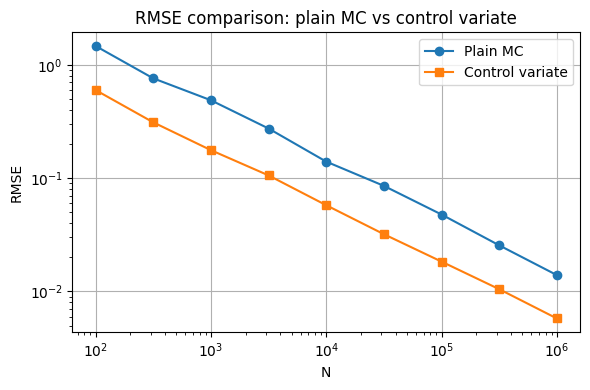

In [12]:
true_price = bs_call_price(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)  
R = 200  # repetitions per N

rmse_plain = []
rmse_cv = []

rng = np.random.default_rng(123)

for N in N_values:
    err_plain = np.empty(R)
    err_cv = np.empty(R)

    for i in range(R):
        # plain MC
        price_plain = mc_european_call(S0, K, r, sigma, T, N, rng=rng)
        # control variate MC
        price_cv, _ = mc_european_call_cv(S0, K, r, sigma, T, N, rng=rng)

        err_plain[i] = price_plain - true_price
        err_cv[i] = price_cv - true_price

    rmse_plain.append(np.sqrt(np.mean(err_plain**2)))
    rmse_cv.append(np.sqrt(np.mean(err_cv**2)))

rmse_plain = np.array(rmse_plain)
rmse_cv = np.array(rmse_cv)

plt.figure(figsize=(6, 4))
plt.loglog(N_values, rmse_plain, marker='o', label="Plain MC")
plt.loglog(N_values, rmse_cv, marker='s', label="Control variate")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("RMSE comparison: plain MC vs control variate")
plt.grid(True, which="major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/RMSE_comparison_control_variate.png", dpi=300, bbox_inches="tight")
plt.show()

We can see that this reduces the RMSE in the same way that the antithetic method did. We now consider another variance reduction method: stratified sampling.

### Stratified Sampling

Standard Monte Carlo draws samples independently from the full distribution, which leads to random clustering: some regions of the distribution may receive many simulated points while others receive few.  
Stratified sampling reduces this variability by forcing the samples to explore the distribution more uniformly.

To simulate $Z \sim \mathcal{N}(0,1)$ using $N$ stratified samples, we partition the unit interval into $N$ equal subintervals,
$$
\Big[ \tfrac{0}{N}, \tfrac{1}{N} \Big],\;
\Big[ \tfrac{1}{N}, \tfrac{2}{N} \Big],\;
\dots,\;
\Big[ \tfrac{N-1}{N}, 1 \Big],
$$
and draw exactly one uniform point from each subinterval.  
If $U'_i \sim \mathrm{Uniform}(0,1)$, the stratified uniforms are
$$
U_i = \frac{i + U'_i}{N},
\qquad i = 0,\dots,N-1.
$$
To obtain normal samples we then apply the inverse CDF,
$$
Z_i = \Phi^{-1}(U_i).
$$

This construction eliminates the random clustering present in ordinary sampling.  
The resulting estimator remains unbiased but has a smaller variance, since the simulated values of $Z_i$ cover the normal distribution more evenly.

We implement it below.

In [13]:
def mc_european_call_stratified(S0, K, r, sigma, T, N, rng=None):
    
    if rng is None:
        rng = np.random.default_rng()

    # stratified uniforms
    i = np.arange(N)
    U_raw = rng.random(N)          # U'_i ~ Uniform(0,1)
    U = (i + U_raw) / N           

    # map to standard normals
    Z = norm.ppf(U)

    # generate S_T's
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    ST = S0 * np.exp(drift + diffusion)

    # discount payoff
    payoffs = np.maximum(ST - K, 0.0)
    discount_factor = np.exp(-r * T)
    price_estimate = discount_factor * np.mean(payoffs)

    return price_estimate

# sanity check
rng = np.random.default_rng(123)
price_strat = mc_european_call_stratified(S0, K, r, sigma, T, N=50_000, rng=rng)
price_plain = mc_european_call(S0, K, r, sigma, T, N=50_000, rng=rng)
price_bs    = bs_call_price(S0, K, r, sigma, T)

price_plain, price_strat, price_bs


(np.float64(10.417107915402548),
 np.float64(10.450421927246262),
 np.float64(10.450583572185565))

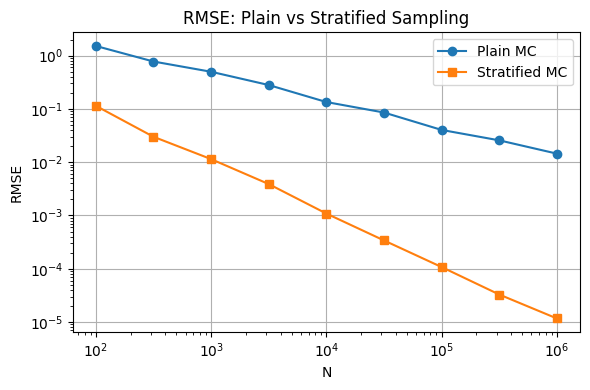

In [14]:
true_price = bs_call_price(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)   # 1e2 ... 1e6
R = 200  # repetitions for RMSE

rmse_plain = []
rmse_strat = []

rng = np.random.default_rng(123)

for N in N_values:
    err_plain = np.empty(R)
    err_strat = np.empty(R)

    for i in range(R):
        # Plain Monte Carlo
        price_plain = mc_european_call(S0, K, r, sigma, T, N, rng=rng)
        # Stratified Monte Carlo
        price_strat = mc_european_call_stratified(S0, K, r, sigma, T, N, rng=rng)

        err_plain[i] = price_plain - true_price
        err_strat[i] = price_strat - true_price

    rmse_plain.append(np.sqrt(np.mean(err_plain**2)))
    rmse_strat.append(np.sqrt(np.mean(err_strat**2)))

rmse_plain = np.array(rmse_plain)
rmse_strat = np.array(rmse_strat)

plt.figure(figsize=(6, 4))
plt.loglog(N_values, rmse_plain, marker='o', label="Plain MC")
plt.loglog(N_values, rmse_strat, marker='s', label="Stratified MC")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("RMSE: Plain vs Stratified Sampling")
plt.grid(True, which="Major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/RMSE_comparison_stratified_sampling.png", dpi=300, bbox_inches="tight")
plt.show()


### Comparing the Variance Reduction Methods

We now compare the performance of all three variance–reduction techniques:

- Antithetic variates  
- Control variates  
- Stratified sampling  

against the plain Monte Carlo estimator.

Each method uses the same number of simulated samples, and for each value of $N$ we repeat the experiment several times to measure the typical size of the error.  
This allows us to see how much each technique reduces variance under the same computational budget.

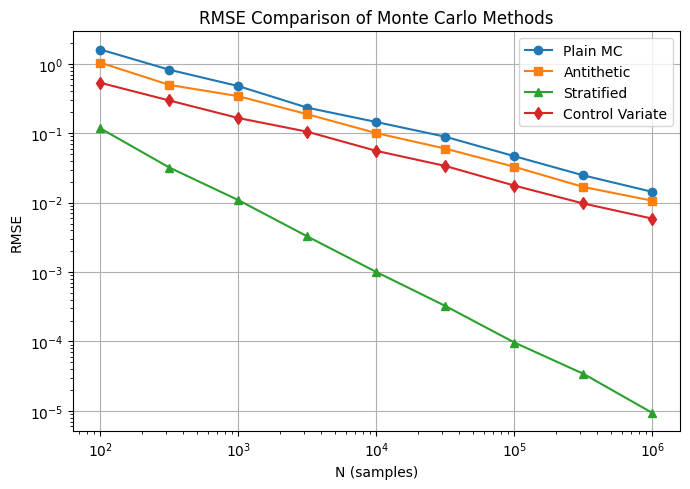

In [15]:
true_price = bs_call_price(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)   
R = 200  # repetitions 

rmse_plain = []
rmse_anti  = []
rmse_strat = []
rmse_cv    = []

rng = np.random.default_rng(123)

for N in N_values:
    err_plain = np.empty(R)
    err_anti  = np.empty(R)
    err_strat = np.empty(R)
    err_cv    = np.empty(R)

    for i in range(R):
        # Plain MC
        price_plain = mc_european_call(S0, K, r, sigma, T, N, rng=rng)
        # Antithetic MC
        price_anti  = mc_european_call_antithetic(S0, K, r, sigma, T, N, rng=rng)
        # Stratified sampling
        price_strat = mc_european_call_stratified(S0, K, r, sigma, T, N, rng=rng)
        # Control variate MC
        price_cv, _ = mc_european_call_cv(S0, K, r, sigma, T, N, rng=rng)

        err_plain[i] = price_plain - true_price
        err_anti[i]  = price_anti  - true_price
        err_strat[i] = price_strat - true_price
        err_cv[i]    = price_cv    - true_price

    rmse_plain.append(np.sqrt(np.mean(err_plain**2)))
    rmse_anti.append(np.sqrt(np.mean(err_anti**2)))
    rmse_strat.append(np.sqrt(np.mean(err_strat**2)))
    rmse_cv.append(np.sqrt(np.mean(err_cv**2)))

rmse_plain = np.array(rmse_plain)
rmse_anti  = np.array(rmse_anti)
rmse_strat = np.array(rmse_strat)
rmse_cv    = np.array(rmse_cv)

plt.figure(figsize=(7, 5))
plt.loglog(N_values, rmse_plain, marker='o', label="Plain MC")
plt.loglog(N_values, rmse_anti,  marker='s', label="Antithetic")
plt.loglog(N_values, rmse_strat, marker='^', label="Stratified")
plt.loglog(N_values, rmse_cv,    marker='d', label="Control Variate")

plt.xlabel("N (samples)")
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Monte Carlo Methods")
plt.grid(True, which="Major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/RMSE_comparison_variance_reduction_methods.png", dpi=300, bbox_inches="tight")
plt.show()


### Conclusion

The numerical experiments confirm the theoretical picture: all four estimators (plain Monte Carlo, antithetic variates, stratified sampling, and the control variate share the same asymptotic convergence rate) 
$$
\mathrm{RMSE} = O(N^{-1/2}),
$$
but differ significantly in the variance constant.

Stratified sampling produces the largest reduction in variance for the European call payoff.  
Because uniform quantiles are mapped through the inverse normal CDF, the sampling covers the probability space in a balanced, nearly deterministic way. This reduces variability in regions where the payoff is most sensitive.  

The control variate method also yields a substantial improvement, driven by the very strong correlation between the payoff and the chosen control. Antithetic variates offer a moderate but reliable reduction in variance.  

These results highlight an important principle: performance gains in Monte Carlo arise from lowering the estimator variance, not from altering the fundamental $N^{-1/2}$ convergence rate.

## Computing Greeks

In option pricing, Greeks are the sensitivities of an option’s value with respect to underlying parameters of the model.  
If the option price is written as a function  
$$
C = C(S_0,\, K,\, r,\, \sigma,\, T),
$$
then the Greeks measure how $C$ changes when each input is perturbed. They play a central role in risk management, hedging, and numerical methods.

The most common Greeks are:

- **Delta**  
  Sensitivity to the underlying price:  
  $$
  \Delta = \frac{\partial C}{\partial S_0}.
  $$

- **Gamma**  
  Sensitivity of Delta to the underlying price (curvature):  
  $$
  \Gamma = \frac{\partial^2 C}{\partial S_0^2}.
  $$

- **Vega**  
  Sensitivity to volatility:  
  $$
  \text{Vega} = \frac{\partial C}{\partial \sigma}.
  $$

- **Theta**  
  Sensitivity to time to maturity:  
  $$
  \Theta = \frac{\partial C}{\partial T}.
  $$

- **Rho**  
  Sensitivity to the interest rate:  
  $$
  \rho = \frac{\partial C}{\partial r}.
  $$

Each Greek quantifies a different aspect of how the option reacts to market movements or model changes. From a computational viewpoint, estimating Greeks with Monte Carlo requires differentiating expectations with respect to parameters; this introduces additional variance and motivates specialised estimators such as pathwise differentiation and the likelihood-ratio method.

In this project we will investigate two Greeks and their applications to hedging: Delta, Gamma.


### Delta

Delta measures the sensitivity of the option price with respect to the initial underlying value,
$$
\Delta = \frac{\partial C}{\partial S_0}.
$$

For a European call under Black–Scholes, the payoff is differentiable in the underlying asset price except at a single point, so an efficient Monte Carlo estimator can be obtained using the **pathwise derivative** method. This yields an unbiased, low-variance estimator and is the standard approach for smooth payoffs.

To benchmark its performance, we will also compare against a simple **finite-difference estimator**, obtained by perturbing the initial price and approximating the derivative numerically. Although straightforward, the finite-difference method typically suffers from significantly higher variance.

We will use these two approaches to construct and analyse Monte Carlo estimators for $\Delta$, and examine how variance reduction techniques influence their accuracy.


#### Black-Scholes Analytical Delta

In the Black-Scholes model, the call price has the closed-form expression  
$$
C = S_0\,\Phi(d_1) - K e^{-rT}\,\Phi(d_2),
$$
where $\Phi$ is the standard normal CDF and  
$$
d_1 = \frac{\ln(S_0/K) + (r + \tfrac12\sigma^2)T}{\sigma\sqrt{T}}, 
\qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$

Delta is the sensitivity of the call price to the initial asset price,  
$$
\Delta = \frac{\partial C}{\partial S_0}.
$$

Differentiating the formula for $C$ with respect to $S_0$ gives  
$$
\Delta = \Phi(d_1),
$$
since $d_1$ depends on $S_0$ in a way that produces exactly the standard normal density term needed to cancel the second contribution.

Thus, once $d_1$ is computed, the analytical Delta is simply the normal CDF evaluated at $d_1$. We will use this analytical Delta to judge how effective our approaches are.


In [16]:
def bs_call_delta(S, K, r, sigma, tau):
    from scipy.stats import norm
    if tau <= 0:
        return np.where(S > K, 1.0, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)


#### Pathwise Derivative Method

The pathwise derivative method is a technique for computing Greeks by differentiating the payoff inside the Monte Carlo expectation.  
Suppose the option price is written as  
$$
C = \mathbb{E}\!\left[e^{-rT} f(S_T)\right],
$$
where the terminal asset price under Black-Scholes is  
$$
S_T = S_0 \exp\!\Big( (r - \tfrac12\sigma^2)T + \sigma\sqrt{T}\,Z \Big),
\qquad Z \sim N(0,1).
$$

If the payoff function $f$ is differentiable with respect to $S_T$, then by the chain rule, we may interchange differentiation and expectation:
$$
\frac{\partial C}{\partial S_0}
= \mathbb{E}\!\left[
e^{-rT} \frac{\partial f(S_T)}{\partial S_T}
\cdot \frac{\partial S_T}{\partial S_0}
\right].
$$

For a European call,  
$$
f(S_T) = (S_T - K)^+,
$$
which is differentiable except at the single point $S_T = K$, a set of probability zero. Therefore,
$$
\frac{\partial f(S_T)}{\partial S_T} = \mathbf{1}_{\{S_T > K\}}.
$$

Since  
$$
S_T = S_0 \cdot G(Z) \quad \Longrightarrow \quad 
\frac{\partial S_T}{\partial S_0} = \frac{S_T}{S_0},
$$
the pathwise Delta estimator becomes
$$
\Delta_{\text{PW}}
= \mathbb{E}\!\left[
e^{-rT}\,
\mathbf{1}_{\{S_T > K\}}
\cdot \frac{S_T}{S_0}
\right].
$$

In Monte Carlo form, this corresponds to simulating $S_T^{(i)}$ and averaging:
$$
\widehat{\Delta}_{\text{PW}}
= e^{-rT}\,
\frac{1}{N}\sum_{i=1}^N
\mathbf{1}_{\{S_T^{(i)} > K\}}
\cdot \frac{S_T^{(i)}}{S_0}.
$$

The method has two major advantages:
- **Unbiased estimator:** No finite-difference step size or truncation error.
- **Low variance:** Especially effective for smooth payoffs such as vanilla calls and puts.

This makes the pathwise derivative method the standard and most efficient approach for estimating Delta in Monte Carlo for differentiable payoffs.


In [17]:
def mc_delta_pathwise(S0, K, r, sigma, T, N, rng=None):
    """
    Pathwise Monte Carlo estimate of Delta = dC/dS0.
    """
    if rng is None:
        rng = np.random.default_rng()

    # simulate terminal prices S_T
    ST = simulate_ST(S0, r, sigma, T, N, rng=rng)

    # indicator for profitable paths
    itm = (ST > K).astype(float)

    dPayoff_dS0 = itm * (ST / S0)

    # discount
    disc = np.exp(-r * T)
    delta_hat = disc * np.mean(dPayoff_dS0)
    return delta_hat


# sanity check
rng = np.random.default_rng(123)
N = 10**5

delta_mc = mc_delta_pathwise(S0, K, r, sigma, T, N, rng=rng)
delta_bs = bs_call_delta(S0, K, r, sigma, T)

delta_mc, delta_bs


(np.float64(0.6365009923514614), np.float64(0.6368306511756191))

#### Finite-Difference Delta

A simple way to approximate Delta is to perturb the initial asset price and use a numerical derivative.  
For a small step size $h$, the **central finite-difference estimator** is  
$$
\Delta_{\text{FD}}
= \frac{C(S_0 + h) - C(S_0 - h)}{2h},
$$
where each term is a Monte Carlo estimate of the option price at the shifted initial value.

Finite differences require no analytical manipulation and apply to any payoff, but they suffer from two issues:

- **Bias-variance trade-off:**  
  $h$ must be small to reduce bias, but small $h$ increases variance because the two Monte Carlo prices become almost identical and their difference is noisy.

- **Higher computational cost:**  
  Each Greek requires at least two full pricing simulations.

Despite these drawbacks, finite differences provide a useful benchmark against which to compare more efficient analytical estimators like the pathwise method.


In [18]:
def mc_delta_finite_difference(S0, K, r, sigma, T, N, h=1e-2, rng=None):
    """
    Central finite-difference Monte Carlo estimator of Delta.
    """
    if rng is None:
        rng = np.random.default_rng()

    # note it is important to use independent seeds for the generators
    price_up   = mc_european_call(S0 + h, K, r, sigma, T, N, rng=rng)
    price_down = mc_european_call(S0 - h, K, r, sigma, T, N, rng=rng)

    delta_fd = (price_up - price_down) / (2 * h)
    return delta_fd

# sanity check
rng = np.random.default_rng(123)

N = 10**5
h = 1.0  

delta_fd = mc_delta_finite_difference(S0, K, r, sigma, T, N, h=h, rng=rng)
delta_bs = bs_call_delta(S0, K, r, sigma, T)

delta_fd, delta_bs


(np.float64(0.666836560489136), np.float64(0.6368306511756191))

##### Comparison of Pathwise and Finite-Difference Delta Estimators

To assess the efficiency of the two Delta estimators, we compute their RMSEs over a range of sample sizes and compare their convergence behaviour.

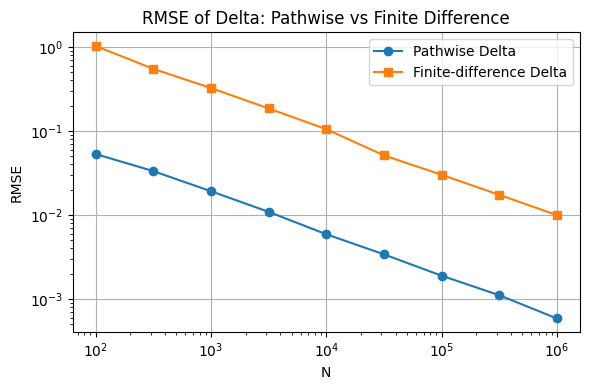

In [19]:
true_delta = bs_call_delta(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)  
R = 200  # repetitions

rmse_pw = []
rmse_fd = []

rng_master = np.random.default_rng(123)
seeds = rng_master.integers(0, 1_000_000_000, size=R)

for N in N_values:
    err_pw = np.empty(R)
    err_fd = np.empty(R)

    for i in range(R):
        rng_i = np.random.default_rng(seeds[i])

        delta_pw = mc_delta_pathwise(S0, K, r, sigma, T, N, rng=rng_i)
        # fresh rng for FD to avoid dependence
        rng_j = np.random.default_rng(seeds[i] + 1)
        delta_fd = mc_delta_finite_difference(S0, K, r, sigma, T, N, h=1.0, rng=rng_j)

        err_pw[i] = delta_pw - true_delta
        err_fd[i] = delta_fd - true_delta

    rmse_pw.append(np.sqrt(np.mean(err_pw**2)))
    rmse_fd.append(np.sqrt(np.mean(err_fd**2)))

rmse_pw = np.array(rmse_pw)
rmse_fd = np.array(rmse_fd)

plt.figure(figsize=(6, 4))
plt.loglog(N_values, rmse_pw, marker='o', label="Pathwise Delta")
plt.loglog(N_values, rmse_fd, marker='s', label="Finite-difference Delta")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("RMSE of Delta: Pathwise vs Finite Difference")
plt.grid(True, which="Major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/delta_computation_pathwise_vs_finite_difference.png", dpi=300, bbox_inches="tight")
plt.show()

#### Interpretation of Results

The RMSE plot shows that both estimators converge at the expected rate of order $N^{-1/2}$, but with a clear difference in efficiency. The pathwise derivative method has much lower RMSE for all sample sizes, indicating that it achieves a more accurate Delta estimate with fewer simulations. This follows from the fact that the pathwise estimator differentiates the payoff directly and does not involve a subtraction of two noisy Monte Carlo prices.

The finite-difference estimator remains noticeably more variable. It requires two full pricing evaluations and the difference between them introduces additional noise. Even with common random numbers, the variance is larger than that of the pathwise method. As a result, finite differences need substantially more samples to reach the same level of accuracy.

These observations show that the choice of estimator has a significant impact on the numerical stability of Delta. For smooth payoffs such as a European call, the pathwise approach is considerably more efficient and is the preferred method in practice.


#### Using Delta to Examine Hedging Error

Delta represents the hedge ratio required to offset small movements in the underlying asset. In the Black-Scholes model, a portfolio consisting of one option and $-\Delta$ units of the underlying can be made locally riskless. In continuous time this leads to perfect replication, but in practice the hedge can only be rebalanced at discrete times.

To illustrate this effect, we simulate paths of the underlying asset and rebalance a delta-hedged portfolio at fixed intervals. The resulting profit-and-loss depends on how frequently the hedge is updated. As the rebalancing interval becomes smaller, the hedging error decreases and the portfolio tracks the option payoff more closely. When the updates are infrequent, the hedge becomes less effective and the error increases.

This experiment shows how the Delta computed by the pathwise method can be used to assess the performance of a discrete-time hedge. It links the numerical estimation of Greeks to the practical interpretation of the Black–Scholes model and highlights the role of Delta in managing risk in a Monte Carlo framework.


In [20]:
def simulate_path_ST(S0, r, sigma, T, N_steps, rng):
    dt = T / N_steps
    Z = rng.standard_normal(N_steps)
    increments = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
    S = np.empty(N_steps + 1)
    S[0] = S0
    S[1:] = S0 * np.exp(np.cumsum(increments))
    return S


def hedging_error_one_path(S0, K, r, sigma, T, N_steps, rebalance_every, rng):
    S = simulate_path_ST(S0, r, sigma, T, N_steps, rng)
    dt = T / N_steps

    # initial hedge
    tau = T
    Delta_prev = bs_call_delta(S[0], K, r, sigma, tau)
    stock_pos = Delta_prev
    cash = -stock_pos * S[0]

    # rebalance over the path
    for t in range(1, N_steps + 1):
        # cash accrues interest each step
        cash *= np.exp(r * dt)

        # rebalance only on designated steps
        if t % rebalance_every == 0:
            tau = T - t*dt
            Delta_new = bs_call_delta(S[t], K, r, sigma, tau)
            change = Delta_new - Delta_prev
            cash -= change * S[t]
            Delta_prev = Delta_new
            stock_pos = Delta_new

    # terminal portfolio vs payoff
    payoff = max(S[-1] - K, 0.0)
    portfolio = stock_pos * S[-1] + cash
    return portfolio - payoff


def hedging_error_distribution(S0, K, r, sigma, T, N_paths, N_steps, rebalance_every):
    rng = np.random.default_rng(123)
    errors = np.empty(N_paths)
    for i in range(N_paths):
        errors[i] = hedging_error_one_path(S0, K, r, sigma, T, N_steps, rebalance_every, rng)
    return errors



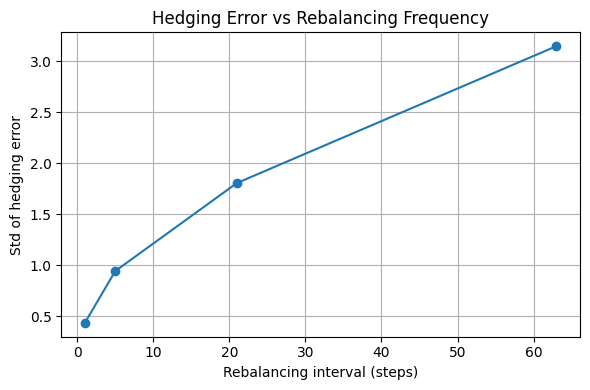

In [21]:
N_paths = 1000
N_steps = 252  # daily steps

frequencies = [1, 5, 21, 63]  # daily, weekly, monthly, quarterly
std_errors = []

for freq in frequencies:
    errors = hedging_error_distribution(S0, K, r, sigma, T, N_paths, N_steps, freq)
    std_errors.append(np.std(errors))

plt.figure(figsize=(6,4))
plt.plot(frequencies, std_errors, marker='o')
plt.xlabel("Rebalancing interval (steps)")
plt.ylabel("Std of hedging error")
plt.title("Hedging Error vs Rebalancing Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/hedging_error_vs_rebalancing_frequency.png", dpi=300, bbox_inches="tight")
plt.show()


#### Hedging Error Interpretation and Role of Delta

The plot shows the standard deviation of the hedging error for different rebalancing intervals. The error is smallest when the hedge is updated at every step (interval $=1$) and increases as the rebalancing interval becomes larger. This is consistent with the idea that a Delta hedge is only locally accurate: between rebalancing times the underlying can move, Delta changes, and the hedge becomes less effective. More frequent rebalancing keeps the hedge closer to the theoretical continuous-time replication implied by the Black-Scholes model.

This experiment illustrates why an accurate estimate of $\Delta$ is important. The hedging strategy is entirely determined by the sequence of Delta values along the path. If Delta is mis-estimated, the hedge ratios are wrong and the hedging error increases. The pathwise estimator provides a low-variance Monte Carlo approximation of Delta, making it suitable for use in such discrete-time hedging simulations.

Greeks therefore connect pricing to risk management: they translate model parameters into quantities that can be used to construct and evaluate hedging strategies. Delta controls the first-order exposure to the underlying; the remaining hedging error comes from higher-order effects. The main one is Gamma, which measures how fast Delta changes with the underlying price. A position with large Gamma requires more frequent rebalancing, and Gamma is the next quantity we consider.

For other Greeks, the same general estimation ideas apply. Pathwise differentiation can be used to obtain estimators for Vega, since the payoff is smooth and the dependence of $S_T$ on $\sigma$ is differentiable. Finite-difference estimators can be constructed for all Greeks, but they typically have higher variance, especially for second derivatives such as Gamma. In the next section we focus on Gamma and examine how its definition and estimation differ from the Delta case.


### Gamma

Gamma measures the curvature of the option price with respect to the underlying asset price, 
or equivalently the sensitivity of Delta to changes in $S_0$. A position with large Gamma has a Delta that changes rapidly when the underlying moves, so it requires more frequent rebalancing to maintain a given hedge.

For a European call under Black-Scholes there is a closed-form expression for Gamma, but in a Monte Carlo setting it is less straightforward to obtain a pathwise estimator: the second derivative of the payoff introduces a point mass at the strike. In practice, Gamma is therefore usually computed by finite differences, for example by applying a central difference to the option price or to Delta.

In what follows we construct a finite-difference Monte Carlo estimator for Gamma and compare it to the analytical value. This allows us to examine the additional numerical difficulty of estimating second derivatives compared with Delta.


#### Gamma Estimation

Gamma measures the curvature of the option price with respect to the underlying asset price. It is defined as
$$
\Gamma = \frac{\partial^2 C}{\partial S_0^2}.
$$
In the Black-Scholes model the analytical expression is
$$
\Gamma = \frac{\phi(d_1)}{S_0 \sigma \sqrt{T}},
\qquad 
d_1 = \frac{\ln(S_0/K) + (r + \tfrac12\sigma^2)T}{\sigma\sqrt{T}},
$$
where $\phi$ is the standard normal density.

In a Monte Carlo setting the payoff does not admit a smooth second derivative, so a direct pathwise estimator is not available. Gamma is therefore computed using a central finite-difference approximation based on perturbed initial prices,
$$
\Gamma_{\text{FD}}
= \frac{C(S_0+h) - 2C(S_0) + C(S_0-h)}{h^2},
$$
with common random numbers used to reduce variance.


In [22]:
# analytic gamma (BS)

def bs_call_gamma(S0, K, r, sigma, T):
    from scipy.stats import norm
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))


In [23]:
def mc_gamma_finite_difference(S0, K, r, sigma, T, N, h=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # common random numbers
    Z = rng.standard_normal(N)
    drift = (r - 0.5 * sigma**2) * T
    diff  = sigma * np.sqrt(T) * Z

    ST_up   = (S0 + h) * np.exp(drift + diff)
    ST_mid  = (S0     ) * np.exp(drift + diff)
    ST_down = (S0 - h) * np.exp(drift + diff)

    payoff_up   = np.maximum(ST_up - K, 0.0)
    payoff_mid  = np.maximum(ST_mid - K, 0.0)
    payoff_down = np.maximum(ST_down - K, 0.0)

    C_up   = np.exp(-r*T) * np.mean(payoff_up)
    C_mid  = np.exp(-r*T) * np.mean(payoff_mid)
    C_down = np.exp(-r*T) * np.mean(payoff_down)

    return (C_up - 2*C_mid + C_down) / (h**2)

# sanity check
rng = np.random.default_rng(123)

N = 200_000
h = 1.0

gamma_fd = mc_gamma_finite_difference(S0, K, r, sigma, T, N, h=h, rng=rng)
gamma_bs = bs_call_gamma(S0, K, r, sigma, T)

gamma_fd, gamma_bs, abs(gamma_fd - gamma_bs)


(np.float64(0.018482905678835593),
 np.float64(0.018762017345846895),
 np.float64(0.0002791116670113024))

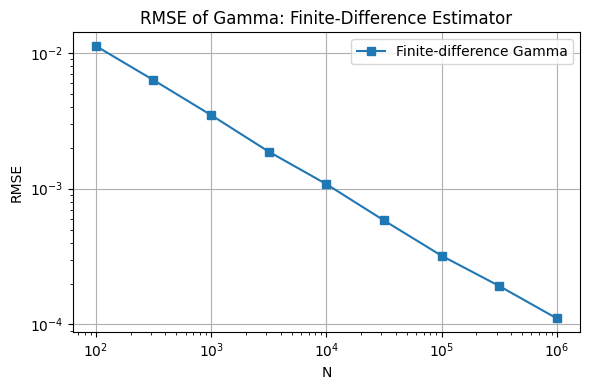

In [24]:
# RMSE comparison for Gamma: finite difference vs analytical Gamma

true_gamma = bs_call_gamma(S0, K, r, sigma, T)

N_values = np.logspace(2, 6, num=9, dtype=int)
R = 200

rmse_gamma_fd = []

rng_master = np.random.default_rng(123)
seeds = rng_master.integers(0, 1_000_000_000, size=R)

for N in N_values:
    err = np.empty(R)
    for i in range(R):
        rng_i = np.random.default_rng(seeds[i])
        gamma_fd = mc_gamma_finite_difference(S0, K, r, sigma, T, N, h=1.0, rng=rng_i)
        err[i] = gamma_fd - true_gamma
    rmse_gamma_fd.append(np.sqrt(np.mean(err**2)))

rmse_gamma_fd = np.array(rmse_gamma_fd)

plt.figure(figsize=(6, 4))
plt.loglog(N_values, rmse_gamma_fd, marker='s', label="Finite-difference Gamma")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.title("RMSE of Gamma: Finite-Difference Estimator")
plt.grid(True, which="Major")
plt.legend()
plt.tight_layout()
plt.savefig("figs/RMSE_gamma_computation_finite_difference.png", dpi=300, bbox_inches="tight")
plt.show()


#### Interpretation of Gamma Results

The RMSE plot shows that the finite-difference Gamma estimator converges at the expected Monte Carlo rate of order $N^{-1/2}$. The error decreases consistently as the number of samples increases, but the overall variance level is higher than for Delta. This is typical for second derivatives: the finite-difference formula involves the difference of three Monte Carlo prices, and the curvature of the payoff around the strike makes the estimator more sensitive to sampling variation.

Despite this, the estimator remains stable when common random numbers are used, and the convergence behaviour is clear. The analytical Gamma provides a reliable benchmark against which the finite-difference estimator can be assessed, and the results show that Monte Carlo can recover the second-order sensitivity with reasonable accuracy.

These observations highlight a general feature of Monte Carlo Greeks. First-order quantities such as Delta can often be estimated efficiently using pathwise derivatives, while higher-order quantities such as Gamma usually require finite differences and therefore exhibit higher variance. The numerical cost of estimating these sensitivities reflects the increasing complexity of the payoff’s dependence on the underlying.


##### Using Gamma for Hedging Error Analysis

Gamma measures the curvature of the option value with respect to the underlying price. After a delta hedge is applied, the leading-order change in the remaining position is governed by this curvature. In discrete time the hedge cannot track every movement in the underlying, and the residual change behaves approximately like a second-order term proportional to the size of the price move.

Large Gamma therefore corresponds to greater sensitivity to short-term movements in the underlying, higher variance in the hedging error, and a stronger dependence on how frequently the position is rebalanced. An accurate estimate of Gamma allows us to quantify this second-order contribution and examine how hedging performance varies across different strike levels under the simulation model.


##### Approach for Investigating the Effect of Gamma on Hedging Error

To examine how Gamma influences discrete‐time hedging performance, we vary the strike of the option while keeping all other model parameters fixed. Changing the strike alters the curvature of the option value at time zero: near-the-money options have high initial Gamma, whereas deep in- or out-of-the-money options have much smaller Gamma.

For each strike we compute the analytical Gamma at inception and run a delta‐hedging simulation with a fixed rebalancing frequency. The standard deviation of the resulting hedging error provides a measure of how sensitive the strategy is to discrete rebalancing under that particular curvature.

By comparing the hedging error across strikes, we can observe how larger initial Gamma leads to larger residual variance after delta hedging. This allows us to link the magnitude of Gamma directly to the effectiveness of discrete hedging in the Monte Carlo model.


In [ ]:
# strikes for a smooth Gamma curve
strike_list = np.arange(70, 131, 5)

# simulation parameters
N_paths = 5000
N_steps = 252
rebalance_every = 5   # weekly hedging

initial_gammas = []
hedge_errors = []

for K_test in strike_list:
    gamma0 = bs_call_gamma(S0, K_test, r, sigma, T)
    initial_gammas.append(gamma0)
    
    errors = hedging_error_distribution(
        S0, K_test, r, sigma, T,
        N_paths, N_steps, rebalance_every
    )
    hedge_errors.append(np.std(errors))

initial_gammas = np.array(initial_gammas)
hedge_errors = np.array(hedge_errors)

# sort by Gamma to produce a clean curve
idx = np.argsort(initial_gammas)

plt.figure(figsize=(6,4))
plt.plot(initial_gammas[idx], hedge_errors[idx], marker='o')
plt.xlabel("Initial Gamma")
plt.ylabel("Std of hedging error")
plt.title("Hedging Error vs Initial Gamma")
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/hedging_error_vs_initial_gamma.png", dpi=300, bbox_inches="tight")
plt.show()


##### Conclusion

The plot shows how the hedging error varies with the initial Gamma of the option when the rebalancing frequency is held fixed. As the strike approaches the at-the-money region the initial Gamma increases sharply, and the standard deviation of the hedging error increases with it. This reflects the fact that a delta hedge compensates only for first-order movements in the underlying. When Gamma is large, Delta changes more rapidly between rebalancing times, and the discrete hedge cannot track these changes exactly. The residual variation therefore grows in proportion to the curvature of the option value.

Deep in- or out-of-the-money options have small Gamma and generate smaller hedging errors under the same rebalancing scheme, since Delta remains relatively stable along the path. The results illustrate the role of Gamma in quantifying the second-order exposure that remains after delta hedging, and how this curvature influences the effectiveness of discrete hedging in the simulation model.


## Project Conclusion

The aim of this project was to examine Monte Carlo methods for pricing and risk analysis in the Black-Scholes model, and to evaluate how variance reduction and sensitivity estimation affect both numerical accuracy and hedging performance. Starting from the basic Monte Carlo estimator, we introduced stratified sampling and control variates and observed the substantial improvement in convergence that simple variance reduction techniques can deliver. These results show that even in a model with a closed-form solution, Monte Carlo remains a flexible and effective numerical tool when combined with appropriate refinements.

The study of Delta and Gamma highlighted how pathwise and finite-difference estimators behave for different orders of sensitivity. Delta admits a low–variance pathwise derivative, while Gamma requires finite differences and therefore exhibits higher sampling error. This difference becomes relevant in applications: estimating first-order sensitivities is straightforward and accurate, while higher-order quantities require more care. The hedging simulations confirmed the theoretical interpretation. Discrete delta hedging leaves a residual error whose magnitude is controlled by the curvature of the option value. Options with high initial Gamma generate larger hedging variance under the same rebalancing schedule, illustrating how second-order exposures govern the effectiveness of practical hedging strategies.

Overall, the project shows how pricing, Greeks, variance reduction, and hedging are connected through the structure of the model. Monte Carlo methods provide a unified framework for approximating these quantities even when closed-form expressions are unavailable, and the behaviour observed in the Black–Scholes test case extends naturally to more complex models. In a real setting this allows the same numerical machinery to be applied to path-dependent options, multi-asset payoffs, or stochastic volatility models, where analytic formulas do not exist and risk sensitivities must be computed directly from simulation. The techniques developed here therefore form the basis for practical risk management and model evaluation beyond the simplest cases.
